# Amazon food review dataset apply LSTM

Data set from https://www.kaggle.com/snap/amazon-fine-food-reviews


# Objective
1. Create vocabulary, get frequancy then index data convert data into imdb dataset format
2. Run LSTM and report accuracy for 10 epoch, try 2 layer of lstm(add one more layer with imdb)

# Import data and libraries
 

In [200]:
from sklearn.manifold import TSNE
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split,KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
np.random.seed(7)
con = sqlite3.connect('database.sqlite') 
#get only +ve and -ve review 
raw_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 

# Data preprocessing

In [201]:
filtered_data=raw_data
# Score>3 a positive rating, and score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

filtered_data.sample(5)
filtered_data['Score'].value_counts()

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries for same profilename,userid, time, text and take first element 
sorted_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)


In [202]:
#take only 20000 data
print('total data \n',sorted_data['Score'].value_counts())
#take stratified sampling i.e. positive and negative reviews are proportionate to raw data
_ , clean_data = train_test_split(sorted_data, test_size = 20000, random_state=0,stratify = sorted_data['Score'] )
clean_data['Score'].value_counts()
topitem=5000
nb_epoch=6

total data 
 positive    307063
negative     57110
Name: Score, dtype: int64


In [203]:
# Clean html tag and punctuation
import warnings
warnings.filterwarnings('ignore')
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

#substitute html tag and punctuation
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
#print(sno.stem('tasty'))

i=0
str1=' '
mystop={'of','four','one','would'}
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
#Create new catagory as Cleanedtext after removing htmltag and punctuation and uppercase and word length >2
for sent in clean_data['Text'].values:
    #change later
    #sent=sent[:20]
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if((cleaned_words.lower() not in stop) & (cleaned_words.lower() not in mystop)):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (clean_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(clean_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1
    
clean_data['CleanedText']=final_string
print(clean_data.shape)
#Sort data on timestamp
clean_data=clean_data.sort_values(by=['Time'],ascending=False)
#clean_data
clean_data['CleanedText'].sample(2)

(20000, 11)


11324    b'miniatur hershey delici period satisfi diabe...
83373    b'nice joke gift smoker work like real pipe us...
Name: CleanedText, dtype: object

# Split train and test

In [204]:
x=clean_data['CleanedText'].values
y = clean_data['Score']
n=x.shape[0]
n1=int(n*.3)
X_test_raw = x[0:n1]
X_train_raw= x[n1:n+1]
y_test=y[0:n1]
y_train=y[n1:n+1]

print('size of X_train, X_test, y_train , y_test ',X_train_raw.shape, X_test_raw.shape,y_train.shape,y_test.shape)
print("positive and negative review in train and test\n",y_train.value_counts(),"\n",y_test.value_counts())

from sklearn.preprocessing import label_binarize
encoded_column_vector = label_binarize(y_train, classes=['negative','positive']) # negative will be 0 and positive will be 1
encoded_labels = np.ravel(encoded_column_vector) # Reshape array
y_train=encoded_labels

encoded_column_vector = label_binarize(y_test, classes=['negative','positive']) # negative will be 0 and positive will be 1
encoded_labels = np.ravel(encoded_column_vector) # Reshape array
y_test=encoded_labels

size of X_train, X_test, y_train , y_test  (14000,) (6000,) (14000,) (6000,)
positive and negative review in train and test
 positive    11902
negative     2098
Name: Score, dtype: int64 
 positive    4962
negative    1038
Name: Score, dtype: int64


## Create dictionary of words
 First create dict with word frequency then sort descending

In [205]:
# Form dictionary from train as word and freq
from collections import defaultdict
fq= defaultdict( int )
for sent in X_train_raw:
  for w in sent.split():
    fq[w] += 1
    
#Sort dictionary on descending of freq
from collections import OrderedDict
from operator import itemgetter    
sorteddict=OrderedDict(sorted(fq.items(), key = itemgetter(1), reverse = True))

import collections
#Take top items and sort again
sorteddictnew=dict(collections.Counter(sorteddict).most_common(topitem))
sorteddictnew=OrderedDict(sorted(sorteddictnew.items(), key = itemgetter(1), reverse = True))

#change values of freq top with 1 then 2 ,3,4 like that
for i, k in enumerate(sorteddictnew):
    sorteddictnew[k]=i+1

## Replace train and test words with the rank from dictionary

In [206]:
#replace each word with its index form dict
final_string=[]
for sent in X_train_raw:
    filtered_sentence=[]
    for w in sent.split():
       try:
         s=list(sorteddictnew.keys()).index(w) 
         filtered_sentence.append(s)   
       except:
         continue
       
    final_string.append(filtered_sentence)
X_train_new=final_string


#replace each word with its index form dict
final_string=[]
for sent in X_test_raw:
    filtered_sentence=[]
    for w in sent.split():
       try:
         s=list(sorteddictnew.keys()).index(w) 
         filtered_sentence.append(s)   
       except:
         continue
    final_string.append(filtered_sentence)
X_test_new=final_string

## Create padding in the input 

In [207]:
X_train=X_train_new
X_test=X_test_new

# truncate and/or pad input sequences
max_review_length = 600
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)

(14000, 600)


## Create model
1 Layer LSTM

In [208]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(topitem, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 600, 32)           160000    
_________________________________________________________________
lstm_15 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


Train on 14000 samples, validate on 6000 samples
Epoch 1/6
14000/14000 [==============================] - 460s 33ms/step - loss: 0.3500 - acc: 0.8670 - val_loss: 0.2683 - val_acc: 0.8908
Epoch 2/6
14000/14000 [==============================] - 492s 35ms/step - loss: 0.1972 - acc: 0.9241 - val_loss: 0.2631 - val_acc: 0.8932
Epoch 3/6
14000/14000 [==============================] - 486s 35ms/step - loss: 0.1546 - acc: 0.9419 - val_loss: 0.2830 - val_acc: 0.8948
Epoch 4/6
14000/14000 [==============================] - 504s 36ms/step - loss: 0.1264 - acc: 0.9522 - val_loss: 0.2903 - val_acc: 0.8902
Epoch 5/6
14000/14000 [==============================] - 542s 39ms/step - loss: 0.1039 - acc: 0.9635 - val_loss: 0.3292 - val_acc: 0.8935
Epoch 6/6
14000/14000 [==============================] - 525s 38ms/step - loss: 0.0846 - acc: 0.9704 - val_loss: 0.3437 - val_acc: 0.8838
Accuracy: 88.38%


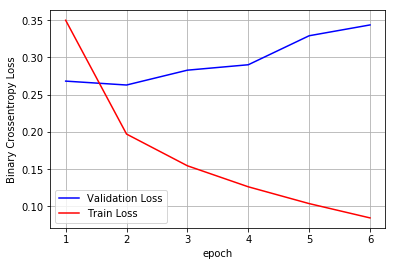

In [209]:
import warnings
warnings.filterwarnings('ignore')
history=model.fit(X_train, y_train, nb_epoch=nb_epoch, batch_size=64,validation_data=(X_test, y_test))
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')
x = list(range(1,nb_epoch+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)


In [210]:
aa=pd.DataFrame({'type':['LSTM 1 layer 100'],'test_accuracy':[scores[1]*100],'test_score':[scores[0]*100]})


2 Layer LSTM

In [211]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(topitem, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#param in 2nd LSTM=4*100(100+100+1) m and n are both 100.  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 600, 32)           160000    
_________________________________________________________________
lstm_16 (LSTM)               (None, 600, 100)          53200     
_________________________________________________________________
lstm_17 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_11 (Dense)             (None, 250)               25250     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 251       
Total params: 319,101
Trainable params: 319,101
Non-trainable params: 0
_________________________________________________________________
None


Train on 14000 samples, validate on 6000 samples
Epoch 1/6
14000/14000 [==============================] - 1192s 85ms/step - loss: 0.3224 - acc: 0.8774 - val_loss: 0.2624 - val_acc: 0.8902
Epoch 2/6
14000/14000 [==============================] - 1219s 87ms/step - loss: 0.1895 - acc: 0.9262 - val_loss: 0.2708 - val_acc: 0.8958
Epoch 3/6
14000/14000 [==============================] - 1205s 86ms/step - loss: 0.1466 - acc: 0.9456 - val_loss: 0.2721 - val_acc: 0.8913
Epoch 4/6
14000/14000 [==============================] - 1158s 83ms/step - loss: 0.1251 - acc: 0.9526 - val_loss: 0.3184 - val_acc: 0.8867
Epoch 5/6
14000/14000 [==============================] - 1156s 83ms/step - loss: 0.0948 - acc: 0.9684 - val_loss: 0.3617 - val_acc: 0.8887
Epoch 6/6
14000/14000 [==============================] - 27477s 2s/step - loss: 0.0751 - acc: 0.9742 - val_loss: 0.4288 - val_acc: 0.8847
Accuracy: 88.47%


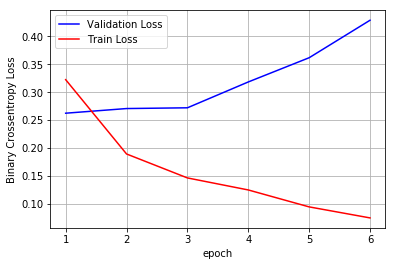

In [212]:
import warnings
warnings.filterwarnings('ignore')
history=model.fit(X_train, y_train, nb_epoch=nb_epoch, batch_size=64,validation_data=(X_test, y_test))
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Binary Crossentropy Loss')
x = list(range(1,nb_epoch+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)


In [213]:
bb=pd.DataFrame({'type':['LSTM 2 layer 100'],'test_accuracy':[scores[1]*100],'test_score':[scores[0]*100]})
aa=aa.append(bb)

# Observation
Model quickly overfit after 2 epoch
The 2 different model accuracy is below


In [214]:
aa

,test_accuracy,test_score,type
0,88.383333,34.372077,LSTM 1 layer 100
0,88.466667,42.875659,LSTM 2 layer 100
